# Survival Analysis in Python

Light bulb data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empyrical_dist import Pmf, Cdf, Surv, Hazard

### Analysis of light bulb lifetimes

I'll use light bulb lifetimes to explain survival and hazard curves and to demonstrate the library I use to compute them.


I downloaded the data from from [https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1], which includes this documentation:

```
Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: 
Theory and Experiment. Journal of Failure Analysis and Prevention. 
December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

Description:

An assembly of 50 new Philips (India) lamps with the 
rating 40 W, 220 V (AC) was taken and installed in the horizontal 
orientation and uniformly distributed over a lab area 11 m by 7 m. 

The assembly was monitored at regular intervals of 12 h to
look for failures. The instants of recorded failures were
called t‘ and a total of 32 data points were obtained such
that even the last bulb failed. 

Variables:

i - observation number
h - time in hours since experiment start
f - number of failed lamps at particular time h
K - number of surviving lamps  at particular time h
```

We can load the data from the CSV file.

In [2]:
df = pd.read_csv("data/lamps.csv")
df.head()

,i,h,f,K
0,0,0,0,50
1,1,840,2,48
2,2,852,1,47
3,3,936,1,46
4,4,960,1,45


The we can make a `Pmf` object that represents the lifetimes of the light bulbs and the fraction of bulbs with each lifetime.

In [3]:
pmf = Pmf(df.f.values, index=df.h)
pmf.normalize()
pmf.head()

h
0      0.00
840    0.04
852    0.02
936    0.02
960    0.02
dtype: float64

Here's what the PMF looks like.

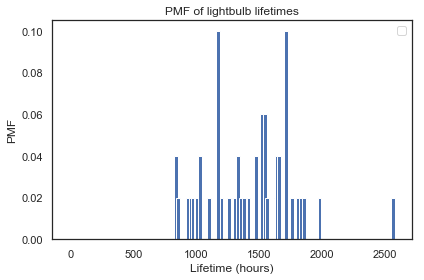

In [4]:
pmf.bar(width=30)
decorate(xlabel='Lifetime (hours)', 
         ylabel='PMF', 
         title='PMF of lightbulb lifetimes')

We can use `make_cdf` to get the corresponding CDF.

In [5]:
cdf = pmf.make_cdf()
cdf.head()

h
0      0.00
840    0.04
852    0.06
936    0.08
960    0.10
dtype: float64

Here's what the CDF looks like.

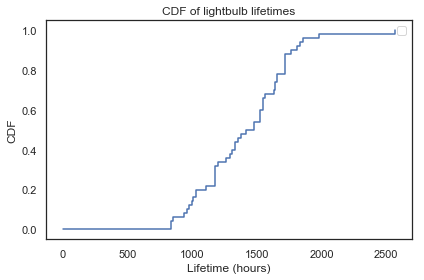

In [6]:
cdf.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='CDF', 
         title='CDF of lightbulb lifetimes')

Next we can use the `Cdf` to make a `Surv` object, which represents a survival function.

In [7]:
surv = cdf.make_surv()
surv.head()

0      1.00
840    0.96
852    0.94
936    0.92
960    0.90
dtype: float64

The survival function is the complement of the CDF.

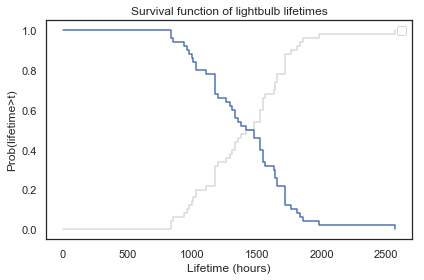

In [8]:
cdf.step(color='gray', alpha=0.3)
surv.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

We can use the `Surv` object to compute the fraction of bulbs that survive past a given lifetime `t`.

In [9]:
surv(-1)

array(1.)

In [10]:
surv(1500)

array(0.46)

In [11]:
surv(3000)

array(0.)

`Surv` provides the usual statistics methods

In [12]:
surv.mean()

1413.8399999999997

In [13]:
surv.std()

343.0379197698119

In [14]:
surv.median()

array(1416.)

These methods work by computing the `Cdf` or `Pmf`.  So if you use them repeatedly, it might be more efficient to compute the `Pmf` and store it.

In [15]:
cdf = surv.make_cdf()
cdf.median()

array(1416.)

In [16]:
pmf = surv.make_pmf()
pmf.mean(), pmf.std()

(1413.8399999999997, 343.0379197698119)

### Hazard function

`Surv` provides `make_hazard`, which computes the hazard function.

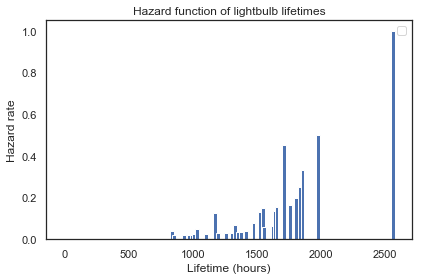

In [17]:
haz = surv.make_hazard()
haz.bar(width=30)
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Hazard function of lightbulb lifetimes')

In [18]:
surv2 = haz.make_surv()

In [19]:
max(abs(surv - surv2))

3.469446951953614e-18

In [20]:
cdf2 = surv2.make_cdf()
max(abs(cdf - cdf2))

0.0

In [21]:
pmf2 = cdf2.make_pmf()
max(abs(pmf.ps - pmf2.ps))

0.0

In [22]:
from scipy.stats import gaussian_kde

def estimate_smooth_hazard(pmf):
    xs = np.linspace(min(pmf.qs), max(pmf.qs))
    
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    pdf = Pmf(kde(xs), index=xs)
    pdf.normalize()
    
    ps = pdf.make_cdf().make_surv().forward(xs)
    surv = Surv(ps, index=xs)
    
    lams = pdf.ps / surv
    haz = Hazard(lams)
    
    return pdf, surv, haz

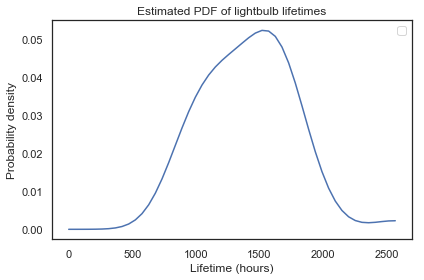

In [23]:
pdf, surv, haz = estimate_smooth_hazard(pmf)
pdf.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Probability density', 
         title='Estimated PDF of lightbulb lifetimes')

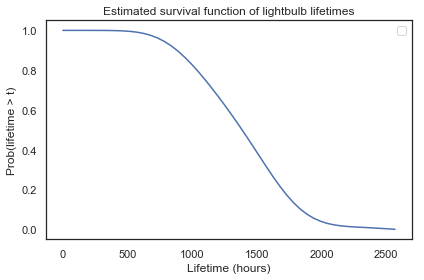

In [24]:
surv.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

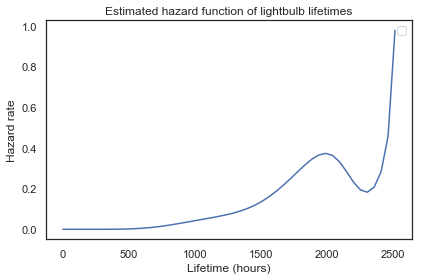

In [25]:
haz.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Estimated hazard function of lightbulb lifetimes')

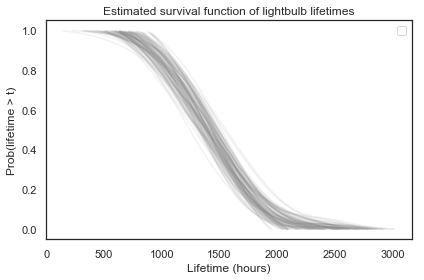

In [26]:
pmf = Pmf(df.f.values, index=df.h)
kde = gaussian_kde(pmf.qs, weights=pmf.ps)

size = pmf.sum()

for i in range(100):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    surv.plot(color='gray', alpha=0.1)
    
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

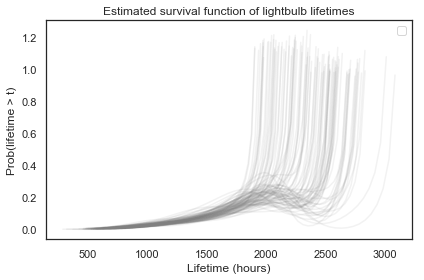

In [27]:
for i in range(100):
    sample = kde.resample(size).flatten()
    pdf, surv, haz = estimate_smooth_hazard(Pmf.from_seq(sample))
    haz.plot(color='gray', alpha=0.1)
    
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Estimated survival function of lightbulb lifetimes')

In [28]:
from collections import Counter

pmf = Pmf(df.f.values, index=df.h)
counter = Counter(dict(pmf.iteritems()))
data = np.fromiter(counter.elements(), dtype=np.int64)
len(data), pmf.sum()

(50, 50)

In [29]:
from scipy.stats import exponweib

a, c, loc, scale = exponweib.fit(data)

/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


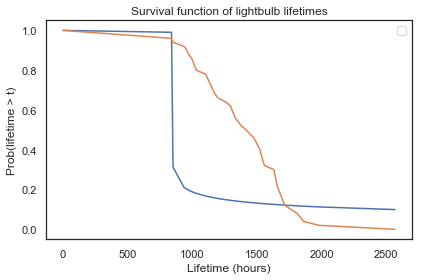

In [30]:
qs = pmf.qs
ps = exponweib(a, c, loc, scale).sf(qs)
plt.plot(qs, ps)

pmf.make_cdf().make_surv().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime > t)', 
         title='Survival function of lightbulb lifetimes')